In [1]:
#%matplotlib inline
#import matplotlib
#print(matplotlib.get_backend())


In [2]:
# Importing Libraries
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from sklearn.mixture import GaussianMixture
from matplotlib.animation import FuncAnimation
import matplotlib.patheffects as pe

In [3]:
def simulate_ball_throwing(init_x, init_y, init_speed, launch_angle, dt, max_time, g=9.81):
    positions = []
    t = 0.0
    vx = init_speed * math.cos(math.radians(launch_angle))
    vy = init_speed * math.sin(math.radians(launch_angle))
    x, y = init_x, init_y

    while t <= max_time and y >= 0:
        positions.append(np.array([x, y]))
        x += vx * dt
        y += vy * dt - 0.5 * g * dt * dt
        vy -= g * dt
        t += dt

    return positions

In [4]:
def simulate_noisy_observations(trajectory, obs_noise_std=1.0, dropout_prob=0.3, dropout_interval=None):
    observations = []
    t = 0
    dropout_start = None
    dropout_end = None
    if dropout_interval:
        dropout_start = np.random.randint(0, len(trajectory) - dropout_interval)
        dropout_end = dropout_start + dropout_interval

    while t < len(trajectory):
        if dropout_interval and dropout_start <= t < dropout_end:
            observations.append(None)
        elif np.random.rand() < dropout_prob:
            observations.append(None)
        else:
            true_pos = trajectory[t]
            noisy_pos = true_pos + np.random.normal(0, obs_noise_std, size=2)
            observations.append(noisy_pos)
        t += 1
    return observations

In [5]:

class UnifiedParticleFilter:
    def __init__(self, num_particles, dt, process_noise_std, observation_noise_std,
                 x_range=(0, 50), y_range=(0, 50), speed_range=(15, 25),
                 angle_range=(30, 60), g=9.81):
        self.N = num_particles
        self.dt = dt
        self.proc_std = process_noise_std
        self.obs_std = observation_noise_std
        self.g = g

        x0 = np.random.uniform(*x_range, size=self.N)
        y0 = np.random.uniform(*y_range, size=self.N)
        speeds = np.random.uniform(*speed_range, size=self.N)
        angles = np.random.uniform(np.radians(angle_range[0]), np.radians(angle_range[1]), size=self.N)
        vx0 = speeds * np.cos(angles)
        vy0 = speeds * np.sin(angles)

        self.particles = np.stack([x0, y0, vx0, vy0], axis=1)
        self.weights = np.ones(self.N) / self.N

    def predict(self):
        for particle in self.particles:
            x, y, vx, vy = particle
            x += vx * self.dt
            y += vy * self.dt - 0.5 * self.g * self.dt ** 2
            vy -= self.g * self.dt

            if y < 0:
                y = 0
                vx = 0
                vy = 0

            particle[:] = [x, y, vx, vy]

    def update(self, observations):
        if not observations:
            return
        likelihood = np.ones(self.N)
        for obs in observations:
            d2 = np.sum((self.particles[:, :2] - obs) ** 2, axis=1)
            likelihood += np.exp(-0.5 * d2 / (self.obs_std ** 2)) 
        self.weights = likelihood / np.sum(likelihood)

    def resample(self):
        positions = (np.arange(self.N) + np.random.rand()) / self.N
        cumulative_sum = np.cumsum(self.weights)
        indices = np.searchsorted(cumulative_sum, positions)
        self.particles = self.particles[indices]
        self.weights.fill(1.0 / self.N)

    def estimategaussian(self, n_clusters, prev_centers=None, min_weight_threshold=0.01):
        positions = self.particles[:, :2]
        positions += np.random.normal(0, 1e-4, size=positions.shape)  # Little jitter

     
        if len(np.unique(positions, axis=0)) < n_clusters:
            return np.tile(np.mean(positions, axis=0), (n_clusters, 1))

        
        gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42)
        gmm.fit(positions)

        
        weights = gmm.weights_
        centers = gmm.means_

        valid_mask = weights >= min_weight_threshold
        if np.sum(valid_mask) < n_clusters:
            
            if prev_centers is not None:
                fallback_centers = prev_centers
            else:
                fallback_centers = np.tile(np.mean(positions, axis=0), (n_clusters, 1))
            return fallback_centers

        valid_centers = centers[valid_mask]

       
        while len(valid_centers) < n_clusters:
            valid_centers = np.vstack([valid_centers, np.mean(positions, axis=0)])

        centers = valid_centers[:n_clusters]  

       
        if prev_centers is None:
            return centers

       
        dists = cdist(prev_centers, centers)
        row_ind, col_ind = linear_sum_assignment(dists)

        aligned_centers = np.zeros_like(centers)
        for i, j in zip(row_ind, col_ind):
            aligned_centers[i] = centers[j]

     
        alpha = 0.7
        smoothed = alpha * prev_centers + (1 - alpha) * aligned_centers

        return smoothed
    
    def estimatekmeans(self, n_clusters, prev_centers=None):
        positions = self.particles[:, :2]
        positions += np.random.normal(0, 1e-4, size=positions.shape)  # jitter


        if len(np.unique(positions, axis=0)) < n_clusters:
            return np.tile(np.mean(positions, axis=0), (n_clusters, 1))

        kmeans = KMeans(n_clusters=n_clusters, n_init='auto').fit(positions)
        centers = kmeans.cluster_centers_

       
        if prev_centers is None:
            return centers

       
        dists = cdist(prev_centers, centers)

       
        row_ind, col_ind = linear_sum_assignment(dists)

        
        aligned_centers = np.zeros_like(centers)
        for i, j in zip(row_ind, col_ind):
            aligned_centers[i] = centers[j]

        
        alpha = 0.7  
        smoothed = alpha * prev_centers + (1 - alpha) * aligned_centers

        return smoothed

In [6]:
def visualize_multimodal(true_trajs, observations_per_ball, est_trajs_per_ball):
    colors = ['deepskyblue', 'magenta', 'green', 'orange']
    stroke = pe.withStroke(linewidth=5, foreground='black')

    plt.figure(figsize=(10, 7))

    for i, (true_xy, est_xy, obs_list) in enumerate(zip(true_trajs, est_trajs_per_ball, observations_per_ball)):
        color = colors[i % len(colors)]

        true_xy = np.array(true_xy)
        plt.plot(true_xy[:, 0], true_xy[:, 1], linestyle='--', color=color, linewidth=3,
                 label=f'True Ball {i+1}', path_effects=[stroke])

        est_xy = np.array(est_xy)
        plt.plot(est_xy[:, 0], est_xy[:, 1], linestyle='-', color='black', linewidth=1.5, label=f'Est Ball {i+1}')

        dropout_indices = []
        obs_xy = []

        for t, o in enumerate(obs_list):
            if o is None:
                dropout_indices.append(t)
            else:
                obs_xy.append(o)

        obs_xy = np.array(obs_xy)
        if len(obs_xy) > 0:
            plt.scatter(obs_xy[:, 0], obs_xy[:, 1], s=10, alpha=0.6, label=f'Obs Ball {i+1}', color=color)

        if len(dropout_indices) > 0:
            dropout_pts = [est_xy[t] for t in dropout_indices if t < len(est_xy)]
            dropout_pts = np.array(dropout_pts)
            plt.scatter(dropout_pts[:, 0], dropout_pts[:, 1], s=60, color='red',
                        marker='x', label=f'Dropout Ball {i+1}')

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Particle Filter with Dropout Highlight")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

In [7]:

def create_particle_filter_animation(true_trajs, observations, particle_histories, est_trajs_per_ball, filename="particle_filter_animation.gif"):
    colors = ['deepskyblue', 'magenta', 'green', 'orange', 'purple', 'brown', 'olive', 'cyan']
    stroke = pe.withStroke(linewidth=5, foreground='black')

    fig, ax = plt.subplots(figsize=(14, 10))
    ax.set_xlim(0, 150)
    ax.set_ylim(0, 100)
    ax.set_title("Particle Filter Animation")

    scat_particles = ax.scatter([], [], s=1, color='black', label='Particles')

    lines_true = [
        ax.plot([], [], linestyle='--', lw=3, path_effects=[stroke], color=colors[i % len(colors)])[0]
        for i in range(len(true_trajs))
    ]

    lines_obs = [
        ax.plot([], [], 'o', markersize=3, alpha=0.5, color=colors[i % len(colors)])[0]
        for i in range(len(observations))
    ]

    lines_est = [
        ax.plot([], [], linestyle='-', lw=2, color='black', label=f'Est Ball {i+1}')[0]
        for i in range(len(est_trajs_per_ball))
    ]

    def update(frame):
        # Particle positions
        xs_particles = [p[0] for p in particle_histories[frame]]
        ys_particles = [p[1] for p in particle_histories[frame]]
        scat_particles.set_offsets(list(zip(xs_particles, ys_particles)))

        # True trajectories
        for i, traj in enumerate(true_trajs):
            xs = [p[0] for p in traj[:frame+1]]
            ys = [p[1] for p in traj[:frame+1]]
            lines_true[i].set_data(xs, ys)

        # Observations
        for i, obs in enumerate(observations):
            xs = [o[0] for o in obs[:frame+1] if o is not None]
            ys = [o[1] for o in obs[:frame+1] if o is not None]
            lines_obs[i].set_data(xs, ys)

        # Estimated trajectories
        for i, est in enumerate(est_trajs_per_ball):
            xs = [p[0] for p in est[:frame+1]]
            ys = [p[1] for p in est[:frame+1]]
            lines_est[i].set_data(xs, ys)

        return scat_particles, *lines_true, *lines_obs, *lines_est

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid()
    plt.tight_layout()

    anim = FuncAnimation(fig, update, frames=len(particle_histories), interval=100)
    anim.save(filename, writer='pillow', fps=10)
    plt.close()
    print(f"Animation saved as {filename}")


In [8]:

def run_multimodal_particle_filter_simulation():
    N_BALLS = 3
    DT = 0.01
    MAX_TIME = 10
    NOISE_STD = 1.0
    num_particles = 20000

    init_xs = np.linspace(10, 40, N_BALLS)
    init_ys = np.linspace(10, 40, N_BALLS)
    speeds = np.random.uniform(15, 25, size=N_BALLS)
    angles = np.random.uniform(30, 50, size=N_BALLS)
    dropout_intervals = np.random.randint(10, 30, size=N_BALLS)

    true_trajs = []
    observations_per_ball = []
    all_observations_by_time = []
    max_len = 0

    for i in range(N_BALLS):
        traj = simulate_ball_throwing(init_xs[i], init_ys[i], speeds[i], angles[i], DT, MAX_TIME)
        obs = simulate_noisy_observations(traj, obs_noise_std=NOISE_STD,
                                          dropout_prob=0.15, dropout_interval=dropout_intervals[i])
        obs = [o if o is not None and not np.isnan(o).any() else None for o in obs]
        max_len = max(max_len, len(obs))

        true_trajs.append(traj)
        observations_per_ball.append(obs)

    for t in range(max_len):
        obs_at_t = []
        for b in range(N_BALLS):
            if t < len(observations_per_ball[b]) and observations_per_ball[b][t] is not None:
                obs_at_t.append(observations_per_ball[b][t])
        all_observations_by_time.append(obs_at_t)

    pf = UnifiedParticleFilter(
        num_particles, DT, process_noise_std=0.05,
        observation_noise_std=NOISE_STD,
        x_range=(0, 50), y_range=(0, 50),
        speed_range=(15, 25), angle_range=(30, 60)
    )
    particle_histories = []


    est_trajs_per_ball = [[] for _ in range(N_BALLS)]
    prev_centers = None

    for t in range(max_len):
        pf.predict()
        particle_histories.append(pf.particles.copy())

        if all_observations_by_time[t]:  
            pf.update(all_observations_by_time[t])
            pf.resample()

        cluster_centers = pf.estimatekmeans(n_clusters=N_BALLS, prev_centers=prev_centers)
        prev_centers = cluster_centers

        for i in range(N_BALLS):
            est_trajs_per_ball[i].append(cluster_centers[i])


    for i in range(N_BALLS):
        dropout_count = sum([1 for o in observations_per_ball[i] if o is None])
        print(f"Ball {i+1}: {dropout_count} dropout frames")

    visualize_multimodal(true_trajs, observations_per_ball, est_trajs_per_ball)
    create_particle_filter_animation(true_trajs, observations_per_ball, particle_histories, est_trajs_per_ball)



Ball 1: 57 dropout frames
Ball 2: 76 dropout frames
Ball 3: 65 dropout frames


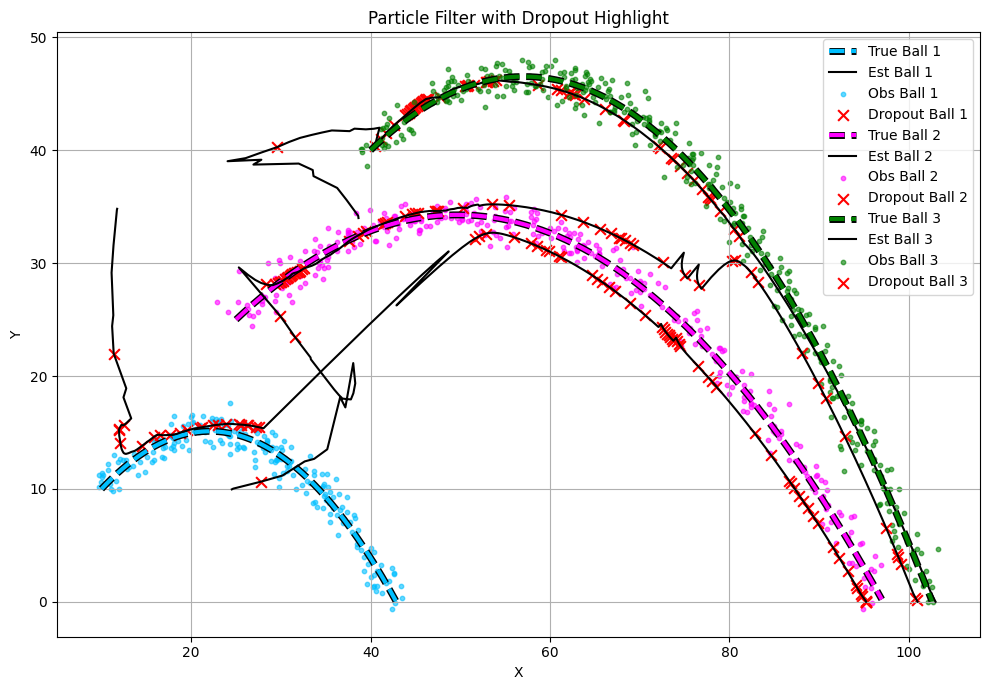

Animation saved as particle_filter_animation.gif


In [9]:
if __name__ == "__main__":
    run_multimodal_particle_filter_simulation()

#### In the multimodal approach, all balls are estimated using a single particle filter with KMeans or GMM clustering. While this allows us to handle indistinguishable objects, it has a key limitation:
#### When many observations are missing due to sensor dropout, the cluster centers can drift or flip, especially when the objects come close to each other. Clustering doesn’t always keep track of which ball is which, so the estimates can suddenly switch between balls.

### -----
### Comparison: 
#### In this project, we used two different methods to estimate the object positions from particles: estimatekmeans and estimategaussian. The estimatekmeans method uses KMeans clustering to find the center points. It also matches the new centers with the previous ones using the Hungarian algorithm and smooths the result to make the movement look more stable.
#### The estimategaussian method works in a similar way but uses a Gaussian Mixture Model (GMM) instead of KMeans. This method also checks how strong each cluster is and removes the ones with very low weights. If there are not enough clusters left, it fills the missing ones with the average position. Like the KMeans version, it also matches and smooths the centers. This method is more useful when there are multiple groups or noise in the data.

### The GMM and KMeans clustering methods give similar results. The average centroid shift is only 0.45 units, indicating that the particle distribution is symmetric and homogeneous. The advantage of more flexible models such as GMM is limited in this case

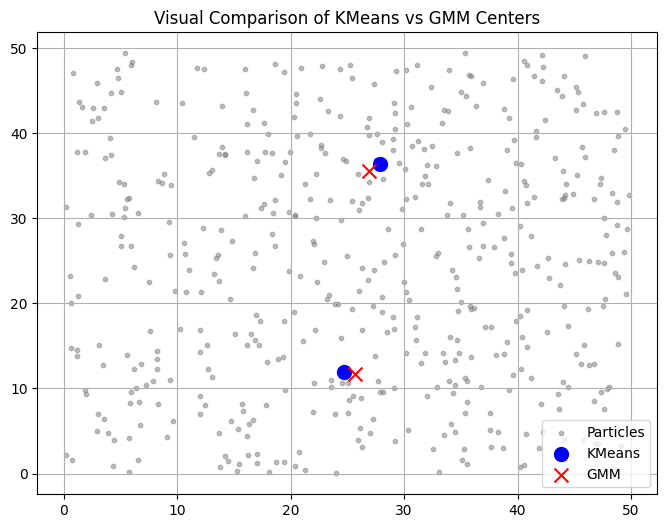

Mean center difference (KMeans vs GMM): 1.1056


In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances


upf = UnifiedParticleFilter(num_particles=500, dt=0.1, process_noise_std=1, observation_noise_std=1)


centers_kmeans = upf.estimatekmeans(n_clusters=2)
centers_gmm = upf.estimategaussian(n_clusters=2)


plt.figure(figsize=(8, 6))
plt.scatter(upf.particles[:, 0], upf.particles[:, 1], s=10, color='gray', alpha=0.5, label="Particles")
plt.scatter(centers_kmeans[:, 0], centers_kmeans[:, 1], color='blue', s=100, marker='o', label="KMeans")
plt.scatter(centers_gmm[:, 0], centers_gmm[:, 1], color='red', s=100, marker='x', label="GMM")
plt.legend()
plt.title("Visual Comparison of KMeans vs GMM Centers")
plt.grid(True)
plt.show()


dist_matrix = pairwise_distances(centers_kmeans, centers_gmm)
row_ind, col_ind = linear_sum_assignment(dist_matrix)
total_shift = dist_matrix[row_ind, col_ind].mean()

print(f"Mean center difference (KMeans vs GMM): {total_shift:.4f}")


In [44]:
from sklearn.metrics import silhouette_score

positions = upf.particles[:, :2]


kmeans = KMeans(n_clusters=2, n_init='auto').fit(positions)
kmeans_labels = kmeans.labels_
score_kmeans = silhouette_score(positions, kmeans_labels)


gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42).fit(positions)
gmm_labels = gmm.predict(positions)
score_gmm = silhouette_score(positions, gmm_labels)

print(f"Silhouette Score - KMeans: {score_kmeans:.4f}")
print(f"Silhouette Score - GMM:    {score_gmm:.4f}")


Silhouette Score - KMeans: 0.3436
Silhouette Score - GMM:    0.3601
